# Numerical Uncertainty Tutorial

## Theory

### Background

<p align="center">
  <img src="./figures/numerical_analysis.png" alt="Image description" />
</p>

**Numerical analysis** is the study of algorithms that use numerical approximation for problems involving mathematical analysis (Trefethen, 1992). Numerical analysis primarily involves studying numerical uncertainty, validating a program’s results, and the optimisation of operations. 

We focus on **numerical uncertainty** in order to get insight on the detection and quantification of numerical errors and their origin. The two methods of investigating numerical uncertainty are static and dynamic analysis. Static analysis analyses a program without executing it, thus it depends greatly on the algorithmic analysis of the program. While effective, static analysis cannot be scaled up to large code bases, which limits its scope. Dynamic analysis analyses a program during or after execution and while efficient, it is not generally as thorough as static analysis and is dependent on the program being analysed and its input data. Nonetheless, it is scalable and can be applied efficiently on large code bases.

**Stochastic arithmetic**, a form of dynamic analysis, analyses a program’s execution to measure numerical error by executing the program multiple times with random numerical perturbations.
Numerical uncertainty is determined by quantifying the errors that can occur in floating point arithmetic, these errors typically being rounding and truncation errors. 
More specifically, one type of rounding error, absorption errors, are caused by mathematical operations between large and small numbers where the shifting of decimal points in the mantissa causes a loss of precision. In turn, another rounding error, catastrophic cancellation, is the loss of leading significant digits caused by subtracting two approximately equal operands.
Two stochastic arithmetic methods that compute numerical uncertainty are DSA (Discrete Stochastic Arithmetic) (Vignes, 2004) and MCA (Monte Carlo Arithmetic) (Parker, 1997). Both techniques leverage randomness to model loss of accuracy inherent to floating point arithmetic due to its finite precision. 


**MCA** is a variant of stochastic arithmetic that leverages randomness in fundamental floating-point operations, introducing a probabilistic element. We use it over DSA due to its scalability to large code bases. It simulates computations for a given virtual precision using the following perturbation: 

$$ inexact(x)=x+2^{e_{x}-t}\xi $$

where 
$$
e_{x} \textnormal{ is the exponent in the floating point representation of } x \\
        t \textnormal{ is the virtual precision and } \\
        \xi \textnormal{ is a random uniform variable of } (-\frac{1}{2},\frac{1}{2})
$$


MCA has three modes that allow perturbation to be introduced in the function input (Precision Bounding---PB), the function output (Random Rounding---RR) or both (full $mca\_mode$).  Full $mca\_mode$ combines RR and PB in the following equation: 

$$mca\_mode(x \circ y)=inexact_{RR}(inexact_{PB}(x) \circ inexact_{PB}(y))$$

Random Rounding tracks rounding errors, while Precision Bounding tracks catastrophic cancellations, and full $mca\_mode$ is a combination of both approaches.

**Verificarlo** (Denis et al., 2015) is a clang-based compiler that replaces floating point operations by a generic call to one of several configurable floating point models available. The source code is available on [Github](https://github.com/verificarlo/verificarlo), with libraries compiled with Verificarlo available on Dockerhub.


<p align="center">
  <img src="./figures/verificarlo.png" alt="Image description" />
</p>

Verificarlo requires recompilation of a program in order to instrument the floating point operations, which is not always feasible on large, complex code bases such as Tensorflow or PyTorch.
This is especially difficult when the clang compiler used by Verificarlo is incompatible with the one used by the program or if the program calls upon many third-party tools which would also require recompilation. 
\
Nonetheless, MCA can be leveraged in programs through the use of the **Fuzzy ecosystem** (Kiar et al., 2020), a collection of Python software packages compiled with Verificarlo.
Fuzzy enables the instrumentation of different libraries by Verificarlo in order to quantify the numerical uncertainty present in code using these libraries.
The [Fuzzy ecosystem](https://github.com/verificarlo/fuzzy) with instrumented packages available such as the Python interpreter, the Numpy and SciPy packages and the libmath library.


<p align="center">
  <img src="./figures/tool_differences.png" alt="Image description" />
</p>


**Verrou** (Févotte et al., 2016) is a tool which also uses Monte Carlo Arithmetic to monitor the accuracy of floating point operations without needing to instrument the source code or recompile it. 
The Verrou tool is located at [Github](https://github.com/edf-hpc/verrou) and its documentation [here](https://edf-hpc.github.io/verrou/vr-manual.html#vr-cr.start-instrumentation).

Verrou is based upon Valgrind (Nethercote et al., 2007), a framework allowing for plug-in tools which use dynamic binary instrumentation (DBI), i.e. the process of modifying instructions of a binary program while it executes.


A comparison of the most popular software implementations of MCA (Verificarlo and Verrou; discussed above) and DSA (CADNA; not discussed in this tutorial, consult (Jezequel et al., 2013)) is shown in the table below:

|                          | **Verificarlo** | **Verrou** | **CADNA** |
|:-------------------------------:|:---------------:|:----------:|:---------:|
| **Theoretical Approach**        |      MCA        |     MCA    |    DSA    |
| **Practical Approach**          |    Compiler     |     DBI    | Manual Implementation |
| **Languages**                   |  C, C++, Fortran| All        | C, C++, Fortran |
| **Perturbation Type**           | RR, PB, full $mca\_mode$| RR, PB, full $mca\_mode$ | RR |
| **Parallelization**             | Yes             | No         | Conditionally upon Synchronisation |


## Practical Examples

In [1]:
import numpy as np
import significantdigits as sd
import seaborn as sns

### Verificarlo

Before beginning, please pull and open up an interactive container of the `verificarlo/fuzzy:nilearn` Docker image. \
When doing so, bind the local `data` directory in this repository to a directory called `/data` in the Docker image, to properly save the files. \
For more practical examples, please consult this [tutorial](https://github.com/verificarlo/fuzzy/tree/master/tutorial) on the Fuzzy repository and this [tutorial](https://github.com/verificarlo/verificarlo_tutorial) on the Verificarlo repository.

The quadratic equation below adapted from the Parker MCA paper can be a suprising example of instability.
$$ 7169x^2 - 8686x + 2631 = 0 $$

In [2]:
#Sample implementation
from scipy.optimize import fsolve

# Define the quadratic equation as a function
def quadratic_eq(x):
    return 7169 * x**2 - 8686 * x + 2631

# Use fsolve to find roots, providing initial guesses
root1 = fsolve(quadratic_eq, 0)  # First guess near zero
root2 = fsolve(quadratic_eq, 1)  # Another guess near one

print("Roots of the quadratic equation are:")
print(root1, root2)

Roots of the quadratic equation are:
[0.60536166] [0.60624387]


You can run the above code located in [```quadratic_eq.py```](https://github.com/InesGP/fuzzy-tutorial/blob/main/scripts/quadratic_eq.py) file in the Fuzzy Docker image and then execute the code cell below to compare your instability to that from the file.

In [ ]:
"""
Execute this cell with your MCA instability
"""

# Specify the file path to the .npy file
file_path = './data/mca_quadratic_results.npy'
# Load the .npy file
data = np.load(file_path)
print("Roots of the quadratic equation are:")
print("r1\t\t\t\tr2")
for r1, r2 in data:
    print(f"{r1:<10.16f} {r2:<10.16f}")
print()
# Inspect the loaded data
print("Computed average: ", np.mean(data,  dtype=np.float64, axis=0))
print("Computed standard deviation: ", np.std(data, dtype=np.float64, axis=0))

In [ ]:
"""
Compare this cell with previously generated instability to your own just above
"""

# Specify the file path to the .npy file
file_path = './data/previous_mca_quadratic_results.npy'
# Load the .npy file
data = np.load(file_path)
print("Roots of the quadratic equation are:")
print("r1\t\t\t\tr2")
for r1, r2 in data:
    print(f"{r1:<10.16f} {r2:<10.16f}")
print()
# Inspect the loaded data
print("Computed average: ", np.mean(data,  dtype=np.float64, axis=0))
print("Computed standard deviation: ", np.std(data, dtype=np.float64, axis=0))

Roots of the quadratic equation are:
r1				r2
0.6053616574595290 0.6062438663216425
0.6053616574596200 0.6062438663217239
0.6053616574596471 0.6062438663217581
0.6053616574596571 0.6062438663217253
0.6053616574595766 0.6062438663216633
0.6053616574594421 0.6062438663216593
0.6053616574595408 0.6062438663217650
0.6053616574596802 0.6062438663216190
0.6053616574596514 0.6062438663218352
0.6053616574596260 0.6062438663218589

Computed average:  [0.60536166 0.60624387]
Computed standard deviation:  [7.03905826e-14 7.67795601e-14]


Another adapted example from the MCA paper demonstrates the impact a machine's floating point precision can have. \
Here, we have an iterative formula where the convergence point changes depending on the numerical precision it is executed in. 

$$
x_0 = 1.5100050721319 \\
x_{k+1} = (3x_k^4 - 20x_k^3 + 35_k^2 - 24) / (4x_k^3 - 30x_k^2 + 70x_k - 50)
$$

In [ ]:
#Sample implementation 

# Define the iterative formula
def iterative_formula(x_k):
    numerator = 3 * x_k**4 - 20 * x_k**3 + 35 * x_k**2 - 24
    denominator = 4 * x_k**3 - 30 * x_k**2 + 70 * x_k - 50
    return numerator / denominator

# Initialize variables
x_k = 1.5100050721319  # Initial guess
iterations = 30

# Perform iterations
results = [x_k]  # To store all iteration results
for _ in range(iterations):
    x_k = iterative_formula(x_k)
    results.append(x_k)

results[-1]  # The value after 30 iterations


The iterative formula converges to: 0.37228132326901436


3.0000000000000426

You can run the above code located in [`convergence_eq.py`](https://github.com/InesGP/fuzzy-tutorial/blob/main/scripts/convergence_eq.py) file in the Fuzzy Docker image and lower the virtual precision to single precision in order to emphasize the instability that can occur. Double precision will still have instability, but it will be less noticeable.
To modify the virtual precision of the script, in the Docker image, run this command:
```
for i in {1..10}; do VFC_BACKENDS="libinterflop_mca.so -m rr --precision-binary32=24 --precision-binary64=53" python convergence_eq.py; done
```
After, you can execute the code cell below and compare your instability to that from the file.

In [ ]:
"""
Execute this cell with your MCA instability
"""

f = open('./data/mca_convergence_results.txt', 'r')
data = []
print("Convergence values after 30 iterations: ")
for value in f:
    i = np.float64(value.strip())
    data.append(i)
    print(i)
print()
# Inspect the loaded data
print("Computed average: ", np.mean(data,  dtype=np.float64, axis=0))
print("Computed standard deviation: ", np.std(data, dtype=np.float64, axis=0))

In [ ]:
"""
Compare this cell with previously generated instability to your own just above
"""

f = open('./data/previous_mca_convergence_results.txt', 'r')
data = []
print("Convergence values after 30 iterations: ")
for value in f:
    i = np.float64(value.strip())
    data.append(i)
    print(i)
print()
# Inspect the loaded data
print("Computed average: ", np.mean(data,  dtype=np.float64, axis=0))
print("Computed standard deviation: ", np.std(data, dtype=np.float64, axis=0))

Convergence values after 30 iterations: 
3.0
3.000000000000071
2.999999999999943
3.0000000000000284
1.0
2.999999999999929
3.0000000000001137
2.9999999999999147
2.9999999999999716
3.000000000000071

Computed average:  2.8000000000000043
Computed standard deviation:  0.6000000000000014


Now we compute the numerical stability of a [Hilbert matrix](https://en.m.wikipedia.org/wiki/Hilbert_matrix). The Hilbert matrices are considered ill-conditioned matrices and are famously difficult to use in numerical computation.

In [3]:
from scipy.linalg import inv

# Function to generate a Hilbert matrix of size n x n
def hilbert_matrix(n):
    return np.fromfunction(lambda i, j: 1.0 / (i + j + 1), (n, n))

# Define the size of the matrix
n = 5  # Example size (can change as needed)

# Generate the Hilbert matrix
H = hilbert_matrix(n)

# Calculate the inverse using scipy.linalg.inv
H_inv = inv(H)

# Display the Hilbert matrix and its inverse
print("Hilbert Matrix:")
print(H)

print("\nInverse of Hilbert Matrix:")
print(H_inv)


Hilbert Matrix:
[[1.         0.5        0.33333333 0.25       0.2       ]
 [0.5        0.33333333 0.25       0.2        0.16666667]
 [0.33333333 0.25       0.2        0.16666667 0.14285714]
 [0.25       0.2        0.16666667 0.14285714 0.125     ]
 [0.2        0.16666667 0.14285714 0.125      0.11111111]]

Inverse of Hilbert Matrix:
[[ 2.500e+01 -3.000e+02  1.050e+03 -1.400e+03  6.300e+02]
 [-3.000e+02  4.800e+03 -1.890e+04  2.688e+04 -1.260e+04]
 [ 1.050e+03 -1.890e+04  7.938e+04 -1.176e+05  5.670e+04]
 [-1.400e+03  2.688e+04 -1.176e+05  1.792e+05 -8.820e+04]
 [ 6.300e+02 -1.260e+04  5.670e+04 -8.820e+04  4.410e+04]]


You can run the above code located in [`hilbert_eq.py`](https://github.com/InesGP/fuzzy-tutorial/blob/main/scripts/hilbert_eq.py) file in the Fuzzy Docker image, and then execute the code cell below to observe the instability in this equation.

In [ ]:
"""
Execute this cell with your MCA instability
"""

# Specify the file path to the .npy file
file_path = './data/mca_hilbert_results.npy'
# Load the .npy file
data = np.load(file_path)

# Inspect the loaded data
print("Computed average: ", np.mean(data,  dtype=np.float64, axis=0))
print("Computed standard deviation: ", np.std(data, dtype=np.float64, axis=0))


sigdig=sd.significant_digits(data , reference=np.mean(data, axis=0, dtype=np.float64), basis=10)
gc = sns.heatmap(sigdig, cmap='RdYlGn', vmax=14, )
gc.set_title("Significant Digit Heatmap for Hilbert Matrix");

Computed average of values: 
 [[ 2.500e+01 -3.000e+02  1.050e+03 -1.400e+03  6.300e+02]
 [-3.000e+02  4.800e+03 -1.890e+04  2.688e+04 -1.260e+04]
 [ 1.050e+03 -1.890e+04  7.938e+04 -1.176e+05  5.670e+04]
 [-1.400e+03  2.688e+04 -1.176e+05  1.792e+05 -8.820e+04]
 [ 6.300e+02 -1.260e+04  5.670e+04 -8.820e+04  4.410e+04]]
Computed standard deviation of values: 
 [[2.02083719e-11 3.80836269e-10 1.64921341e-09 2.49758091e-09
  1.22432262e-09]
 [3.86034906e-10 7.27126768e-09 3.14947527e-08 4.77026912e-08
  2.33850690e-08]
 [1.69050749e-09 3.18448282e-08 1.37936768e-07 2.08922775e-07
  1.02421404e-07]
 [2.57602153e-09 4.86036840e-08 2.10565624e-07 3.18932901e-07
  1.56356269e-07]
 [1.27087175e-09 2.39665129e-08 1.03827982e-07 1.57264195e-07
  7.70972591e-08]]


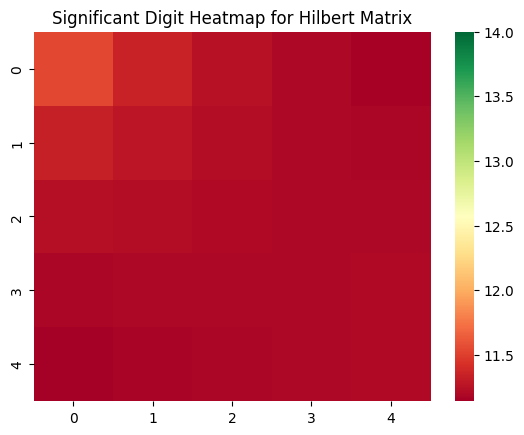

In [8]:
"""
Compare this cell with previously generated instability to your own just above
"""

# Specify the file path to the .npy file
file_path = './data/previous_mca_hilbert_results.npy'
# Load the .npy file
data = np.load(file_path)

# Inspect the loaded data
print("Computed average of values: \n", np.mean(data,  dtype=np.float64, axis=0))
print("Computed standard deviation of values: \n", np.std(data, dtype=np.float64, axis=0))


sigdig=sd.significant_digits(data , reference=np.mean(data, axis=0, dtype=np.float64), basis=10)
gc = sns.heatmap(sigdig, cmap='RdYlGn', vmax=14, )
gc.set_title("Significant Digit Heatmap for Hilbert Matrix");

**Significant digits** (Sohier et al., 2021) are generally defined as the number of digits in common between multiple MCA iterations. They are a metric used to quantify numerical uncertainty, and are implemented at this [Github](https://github.com/verificarlo/significantdigits/tree/main/significantdigits).

### Verrou

For Verrou, run the Docker image containing Verrou and execute the above scripts again. Results should have a similar variability as Verificarlo and Verrou are both implementing the same type of perturbation, through different implementations.

**Quadratic Example**
```
valgrind --tool=verrou --rounding-mode=random python quadratic_eq.py
```
**Convergence Example**
* As before, we run this example completely in single precision (aka float) in order to emphasize the instability that can occur.
```
valgrind --tool=verrou --rounding-mode=random --float=yes python convergence_eq.py
```
**Hibert Example**
```
valgrind --tool=verrou --rounding-mode=random python hilbert_eq.py
```

## References
* L. N. Trefethen, “The definition of numerical analysis,” Cornell University, Tech. Rep., 1992.
* J. Vignes, “Discrete stochastic arithmetic for validating results of numerical software,” Numerical Algorithms, vol. 37, pp. 377–390, 2004.
* D. S. Parker, Monte Carlo Arithmetic: Exploiting Randomness in Floating-Point Arithmetic. University of California (Los Angeles). Computer Science Department, 1997.
* C. Denis, P. D. O. Castro, and E. Petit, “Verificarlo: Checking Floating Point Accuracy through Monte Carlo Arithmetic,” in 2016 IEEE 23nd Symposium on Computer Arithmetic (ARITH). Los Alamitos, CA, USA: IEEE Computer Society, jul 2016, pp. 55–62. [Online]. Available: https://doi.ieeecomputersociety.org/10.1109/ARITH.2016.31
* G. Kiar, P. de Oliveira Castro, P. Rioux, E. Petit, S. T. Brown, A. C. Evans, and T. Glatard, “Comparing Perturbation Models for Evaluating Stability of Neuroimaging Pipelines,” The International Journal of High Performance Computing Applications, vol. 34, no. 5, pp. 491–501, 2020.
* F. Févotte and B. Lathuilière, “Verrou: Assessing Floating-Point Accuracy Without Recompiling,” 2016.
* N. Nethercote and J. Seward, “Valgrind: A Framework for Heavyweight Dynamic Binary Instrumentation,” ACM Sigplan notices, vol. 42, no. 6, pp. 89–100, 2007.
* F. Jezequel, J.-L. Lamotte, and O. Chubach, “Parallelization of discrete stochastic arithmetic on multicore architectures,” in 2013 10th International Conference on Information Technology: New Generations. IEEE, 2013, pp. 160–166.
* D. Sohier, P. D. O. Castro, F. Févotte, B. Lathuilière, E. Petit, and O. Jamond, “Confidence Intervals for Stochastic Arithmetic,” ACM Transactions on Mathematical Software (TOMS), vol. 47, no. 2, pp. 1–33, 2021.

### Tutorial Expansion Ideas

* Significant digit viewer as done here (https://github.com/yohanchatelain/significantdigit-viewer)
* Neuroscience example
* Lead to applications and work done?